In [4]:
## Imports

import csv
import networkx as nx
import time
import matplotlib.pyplot as plt

In [5]:
## Variables

filename = "timetables.csv"
gares = []
connexions = []

In [6]:
## Import gares data

with open(filename, 'r') as file:
    reader = csv.reader(file)

    next(reader)
    for row in reader:
      try:
        row = row[0].split("\t")
        id, trajet, minutes = row

        trajet_depart, trajet_arrivee = trajet.split(" - ")
        trajet_depart = trajet_depart.replace("Gare de ", "")
        trajet_arrivee = trajet_arrivee.replace("Gare de ", "")

        if trajet_depart not in gares:
          gares.append(trajet_depart)
        if trajet_arrivee not in gares:
          gares.append(trajet_arrivee)

        connexions.append((trajet_depart, trajet_arrivee, int(minutes)))

      except ValueError:
        continue

In [7]:
## Define the graph

class ReseauFerroviaire:
    def __init__(self):
        # Non orienté
        self.graph = nx.Graph()
        print("Graph type: Non orienté")

        # Orienté
        # self.graph = nx.DiGraph()
        # print("Graph type: Orienté")

    def ajouter_gare(self, nom):
        self.graph.add_node(nom)

    def ajouter_connexion(self, gare1, gare2, poids=1):
        self.graph.add_edge(gare1, gare2, weight=poids)

    def retirer_connexion(self, gare1, gare2):
        self.graph.remove_edge(gare1, gare2)

    def trouver_chemin(self, depart, arrivee):
      try:
          # Trouver le chemin le plus court
          # A* algorithm
          # chemin = nx.astar_path(self.graph, depart, arrivee, weight='weight')
          # print("Algorithm used: A* algorithm")

          # Dijkstra's algorithm
          chemin = nx.shortest_path(self.graph, depart, arrivee, weight='weight')
          print("Algorithm used: Dijkstra's algorithm")

          # Construire une liste de segments avec poids
          segments = []
          total = 0
          for i in range(len(chemin) - 1):
            gare_depart = chemin[i]
            gare_arrivee = chemin[i + 1]
            poids = self.graph[gare_depart][gare_arrivee]['weight']
            segments.append(f"{gare_depart} -> {gare_arrivee} ({poids} minutes)")
            total += poids

          print(" -> ".join(segments) + ", Temps trajet: " + str(total) + " minutes")
          return chemin

      except nx.NetworkXNoPath:
          return "Aucun chemin trouvé"

    def afficher_graphe(self, chemin=None, depart=None, arrivee=None, filename='graphe.png', layout='kamada_kawai'):
        plt.figure(figsize=(15, 10))  # Ajuster la taille de la figure

        if layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        elif layout == 'spring':
            pos = nx.spring_layout(self.graph, seed=42, k=0.5, iterations=100)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        elif layout == 'shell':
            pos = nx.shell_layout(self.graph)
        else:
            pos = nx.spring_layout(self.graph, seed=42)  # Disposition par défaut

        # Find the shortest path and highlight it
        shortest_path_edges = []
        if depart and arrivee:
            try:
                shortest_path_edges = list(zip(chemin, chemin[1:]))
            except nx.NetworkXNoPath:
                print("No path found between", depart, "and", arrivee)

        print(shortest_path_edges)

        # Assign colors to nodes
        node_color_list = [
          "green" if node == depart else "red" if node == arrivee else "lightblue"
          for node in self.graph.nodes()
        ]

        # Draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_size=500, node_color=node_color_list)

        # Draw edges with different color for the fastest path
        all_edges = set(self.graph.edges())
        other_edges = all_edges - set(shortest_path_edges)

        nx.draw_networkx_edges(self.graph, pos, edgelist=other_edges, arrowstyle='-|>', arrowsize=15, edge_color='gray')
        nx.draw_networkx_edges(self.graph, pos, edgelist=shortest_path_edges, arrowstyle='-|>', arrowsize=15, edge_color='blue', width=2)

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.graph, 'weight')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, label_pos=0.5, font_size=8)

        # Draw node labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_family='sans-serif')

        # Afficher et enregistrer le graphique
        plt.title('Graphe Ferroviaire')
        plt.axis('off')  # Ne pas afficher les axes
        plt.savefig(filename, bbox_inches='tight')  # Sauvegarde le graphique sous forme d'image
        plt.show()

In [8]:
## Configuration

whitelist = [
  "Lyon-Part-Dieu",
  "Paris-Gare-de-Lyon",
  "Lunel",
  "Montpellier-Saint-Roch",
  "Dijon-Ville"
]

depart = "Lunel"
arrivee = "Paris-Gare-de-Lyon"

In [9]:
# Creation du reseau
reseau = ReseauFerroviaire()

# Ajout des gares
for gare in gares:
  if gare in whitelist:
    reseau.ajouter_gare(gare)

# Ajout des connexions
for gare1, gare2, temps in connexions:
  if gare1 in whitelist and gare2 in whitelist:
    reseau.ajouter_connexion(gare1, gare2, poids=temps)

# Ajout de connexions personnalisées
reseau.ajouter_connexion("Montpellier-Saint-Roch", "Lyon-Part-Dieu", poids=150)
# Lyon-Part-Dieu -> Paris-Gare-de-Lyon = 309 -> 120
# Slower
reseau.retirer_connexion("Lyon-Part-Dieu", "Paris-Gare-de-Lyon")
reseau.ajouter_connexion("Lyon-Part-Dieu", "Paris-Gare-de-Lyon", poids=120)
# Lyon-Part-Dieu -> Dijon-Ville = 124
# Dijon-Ville -> Paris-Gare-de-Lyon = 170
# Faster

Graph type: Non orienté


In [10]:
## Recherche d'un chemin le plus rapide
time_start = time.time()
fast_chemin = reseau.trouver_chemin(depart, arrivee)
time_end = time.time()
interval = time_end - time_start
print(f"Time: {interval * 1000} ms")
print(f"Time: {interval} s")

Algorithm used: Dijkstra's algorithm
Lunel -> Montpellier-Saint-Roch (20 minutes) -> Montpellier-Saint-Roch -> Lyon-Part-Dieu (150 minutes) -> Lyon-Part-Dieu -> Paris-Gare-de-Lyon (120 minutes), Temps trajet: 290 minutes
Time: 1.007080078125 ms
Time: 0.001007080078125 s


[('Lunel', 'Montpellier-Saint-Roch'), ('Montpellier-Saint-Roch', 'Lyon-Part-Dieu'), ('Lyon-Part-Dieu', 'Paris-Gare-de-Lyon')]


C:\Users\fvenezia\AppData\Local\Temp\ipykernel_20140\2004641612.py:86: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(self.graph, pos, edgelist=other_edges, arrowstyle='-|>', arrowsize=15, edge_color='gray')
C:\Users\fvenezia\AppData\Local\Temp\ipykernel_20140\2004641612.py:86: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(self.graph, pos, edgelist=other_edges, arrowstyle='-|>', arrowsize=15, edge_color='gray')
C:\Users\fvenezia\AppData\Local\Temp\ipykernel_20140\20046416

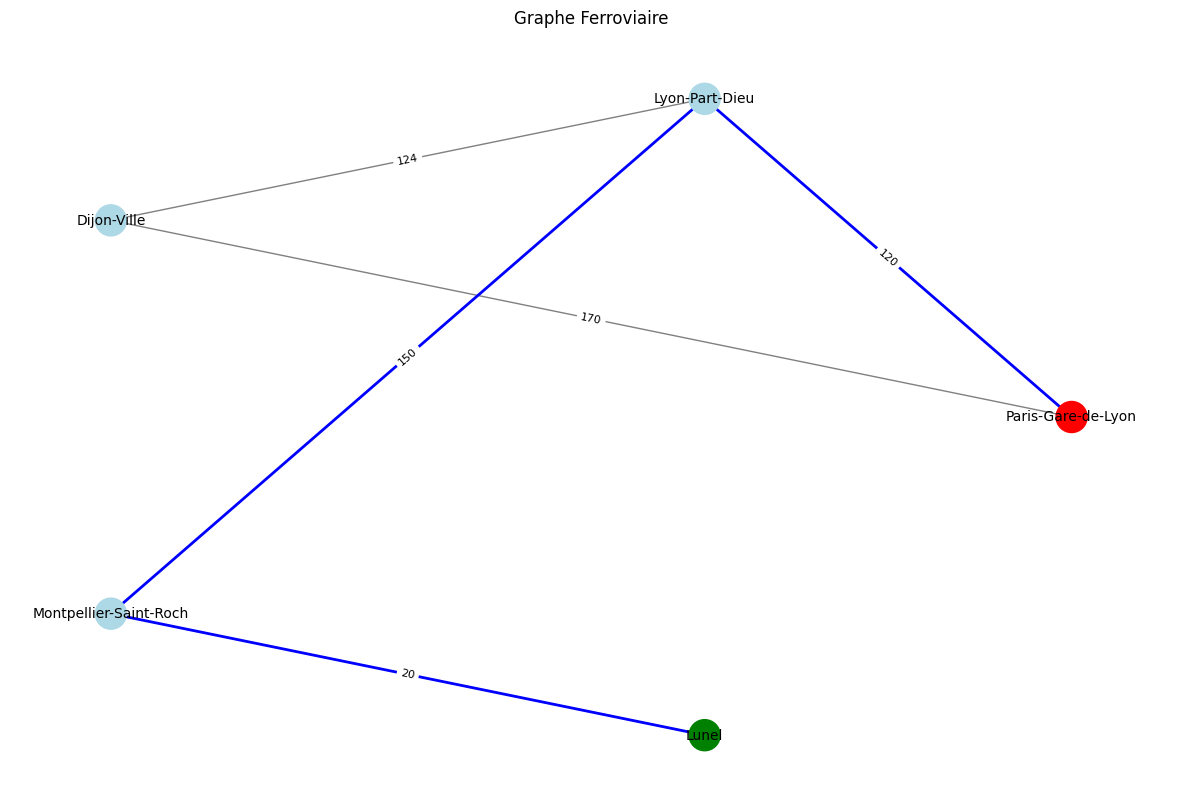

In [11]:
# Afficher le graphe
reseau.afficher_graphe(fast_chemin, depart, arrivee, layout="circular")